# Custom Detector Model

Small end-to-end notebook that defines a simple detection model (single-class, single-box per image), trains from scratch on a WebDataset of images + .txt labels (format [x, y, w, h]) and evaluates with precision/recall and AP (mAP for the single class).

In [165]:
# Imports, device and hyperparameters
import re
import math
import random
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import webdataset as wds
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Hyperparameters
img_size = imgsz = 512
batch_size = 4
epochs = 3
lr = 1e-3
seed = 42
iou_threshold = 0.5
visualize_n = 8

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Device: cuda


In [166]:
transform = transforms.Compose([
    transforms.Resize((imgsz, imgsz)),
    transforms.ToTensor(),
])

def preprocessSample(sample):
     # Detect image key dynamically
    img_key = None
    for k in sample.keys():
        if k.lower() in ["jpg", "jpeg", "png"]:
            img_key = k
            break
    if img_key is None:
        raise ValueError(f"No supported image format found in sample keys: {list(sample.keys())}")

    # Image already decoded to PIL
    img = sample[img_key]
    if img.mode != "RGB":
        img = img.convert("RGB")

    # Get original image size before resizing
    orig_w, orig_h = img.size

    # Resize image
    img_resized = transforms.Resize((imgsz, imgsz))(img)
    new_w, new_h = img_resized.size

    # Compute scale factors (for pixel->pixel conversion if needed)
    scale_x = new_w / orig_w
    scale_y = new_h / orig_h

    # Parse target
    target = sample.get("json", sample.get("txt", sample.get("labels", {})))
    raw_boxes = target.get("boxes", []) if isinstance(target, dict) else []
    # convert to numpy for inspection
    try:
        arr = np.array(raw_boxes, dtype=float)
    except Exception:
        arr = np.array(raw_boxes, dtype=float)

    boxes_norm = []
    if arr.size == 0:
        # no boxes: use a dummy zero box
        boxes_norm.append([0.0, 0.0, 0.0, 0.0])
    else:
        # If values are normalized (<=1.0) we assume they are already in center-format
        # i.e. [x_center, y_center, w, h] normalized to 0..1 (YOLO-style).
        if arr.max() <= 1.0:
            for (x, y, w, h) in arr:
                # treat as center-format normalized directly
                boxes_norm.append([float(x), float(y), float(w), float(h)])
            boxes_norm = [boxes_norm[0]]  # single-box-per-image detector
        else:
            # Treat as absolute pixel top-left [x,y,w,h] -> convert to normalized center after scaling
            for (x, y, w, h) in arr:
                x1, y1, x2, y2 = x, y, x + w, y + h
                x1 *= scale_x; x2 *= scale_x; y1 *= scale_y; y2 *= scale_y
                W, H = imgsz, imgsz
                w_n = (x2 - x1) / W
                h_n = (y2 - y1) / H
                x_center = (x1 + x2) / 2 / W
                y_center = (y1 + y2) / 2 / H
                boxes_norm.append([x_center, y_center, w_n, h_n])
            boxes_norm = [boxes_norm[0]]

    target = target if isinstance(target, dict) else {}
    target["boxes"] = torch.as_tensor(boxes_norm, dtype=torch.float32)
    # ensure labels exist; if not, create a positive label
    if "labels" in target and len(target["labels"]) > 0:
        target["labels"] = torch.as_tensor(target["labels"], dtype=torch.int64)
    else:
        target["labels"] = torch.as_tensor([1], dtype=torch.int64)

    img_tensor = transforms.ToTensor()(img_resized)
    return img_tensor, target

In [167]:
train_dataset = "datasets/custom_augmented/train-00000.tar"
val_dataset = "datasets/custom_augmented/val-00000.tar"
test_dataset = "datasets/custom_augmented/test-00000.tar"

train_dataset = (
    wds.WebDataset(train_dataset)   # <- use pattern or list of tar paths
    .decode("pil")
    .map(preprocessSample)
)
val_dataset = (
    wds.WebDataset(val_dataset)   # <- use pattern or list of tar paths
    .decode("pil")
    .map(preprocessSample)
)
test_dataset = (
    wds.WebDataset(test_dataset)   # <- use pattern or list of tar paths
    .decode("pil")
    .map(preprocessSample)
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=0,
    collate_fn=lambda x: tuple(zip(*x))
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    num_workers=0, 
    collate_fn=lambda x: tuple(zip(*x))
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    num_workers=0, 
    collate_fn=lambda x: tuple(zip(*x))
)

In [168]:
# Debug cell: inspect one batch from train_loader to verify box ranges and a model prediction (if model exists)
print("Debug: examining one batch from train_loader")
for batch in train_loader:
    imgs, targets = batch
    print("batch size:", len(imgs))
    b0 = targets[0]["boxes"][0]
    # print first box raw values
    try:
        print("first target box:", b0 if not isinstance(b0, torch.Tensor) else b0.tolist())
        print("first target box min/max:", float(b0.min()), float(b0.max()))
        print("in_0_1:", bool((b0 >= 0.0).all() and (b0 <= 1.0).all()))
    except Exception as e:
        print('Could not print GT box:', e)
    img = imgs[0]
    print("img min/max:", float(img.min()), float(img.max()), "shape:", img.shape)
    if 'model' in globals():
        model.eval()
        with torch.no_grad():
            imgs_tensor = torch.stack(imgs).to(device)
            pb, ps = model(imgs_tensor)
            pb = pb.cpu().numpy()
            ps = torch.sigmoid(ps).cpu().numpy()
            print("pred box sample:", pb[0], "pred score:", float(ps[0]))
            # compute IoU between pred and GT for first sample
            gt_arr = b0.cpu().numpy() if isinstance(b0, torch.Tensor) else np.array(b0, dtype=float)
            print("pred vs gt iou:", iou_xywh(pb[0], gt_arr))
    break

Debug: examining one batch from train_loader
batch size: 4
first target box: [0.7916666865348816, 0.21378707885742188, 0.11921296268701553, 0.06893542408943176]
first target box min/max: 0.06893542408943176 0.7916666865348816
in_0_1: True
img min/max: 0.0 1.0 shape: torch.Size([3, 512, 512])
pred box sample: [5.6894153e-01 9.1763067e-01 1.7703114e-03 1.4055003e-11] pred score: 1.0
pred vs gt iou: 0.0
batch size: 4
first target box: [0.7916666865348816, 0.21378707885742188, 0.11921296268701553, 0.06893542408943176]
first target box min/max: 0.06893542408943176 0.7916666865348816
in_0_1: True
img min/max: 0.0 1.0 shape: torch.Size([3, 512, 512])
pred box sample: [5.6894153e-01 9.1763067e-01 1.7703114e-03 1.4055003e-11] pred score: 1.0
pred vs gt iou: 0.0


In [169]:
# Model definition: small conv backbone -> global pool -> two heads (bbox and score)
class SimpleDetector(nn.Module):
    def __init__(self, in_channels=3, hidden=64):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels, hidden, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden, hidden, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden, hidden*2, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden*2, hidden*4, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        feat_dim = hidden*4
        self.fc_bbox = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 4),  # x_center, y_center, w, h (normalized 0..1 with sigmoid)
        )
        self.fc_score = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat_dim, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1)  # logits for objectness/class
        )
    def forward(self, x):
        f = self.backbone(x)  # [B, C, 1, 1]
        bbox = self.fc_bbox(f).sigmoid()
        score = self.fc_score(f).squeeze(1)
        return bbox, score

In [170]:
# Utilities: bbox conversions, IoU, AP calculation
def xywh_to_xyxy(box):
    # box: [x_center, y_center, w, h] (normalized 0..1) -> [x1,y1,x2,y2]
    x, y, w, h = box
    x1 = x - w/2
    y1 = y - h/2
    x2 = x + w/2
    y2 = y + h/2
    return [x1, y1, x2, y2]

def iou_xywh(box1, box2):
    a = xywh_to_xyxy(box1)
    b = xywh_to_xyxy(box2)
    xa1, ya1, xa2, ya2 = a
    xb1, yb1, xb2, yb2 = b
    xi1 = max(xa1, xb1)
    yi1 = max(ya1, yb1)
    xi2 = min(xa2, xb2)
    yi2 = min(ya2, yb2)
    iw = max(0.0, xi2 - xi1)
    ih = max(0.0, yi2 - yi1)
    inter = iw * ih
    area_a = max(0.0, (xa2 - xa1)) * max(0.0, (ya2 - ya1))
    area_b = max(0.0, (xb2 - xb1)) * max(0.0, (yb2 - yb1))
    union = area_a + area_b - inter
    return 0.0 if union == 0 else inter / union

import numpy as np
def average_precision(scores, labels, n_gt):
    # scores: array of prediction scores; labels: 1 if TP else 0; n_gt: number of ground-truth boxes
    if len(scores) == 0:
        return 0.0
    order = np.argsort(-scores)
    labels = np.array(labels)[order]
    tp_cum = np.cumsum(labels == 1).astype(float)
    fp_cum = np.cumsum(labels == 0).astype(float)
    precisions = tp_cum / (tp_cum + fp_cum + 1e-8)
    recalls = tp_cum / max(n_gt, 1)
    # integrate precision over recall (11-point or continuous). We'll do continuous:
    # To ensure monotonic precision.
    precisions = np.maximum.accumulate(precisions[::-1])[::-1]
    # append start and end
    mrec = np.concatenate(([0.0], recalls, [1.0]))
    mpre = np.concatenate(([0.0], precisions, [0.0]))
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])
    idx = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])
    return float(ap)

In [175]:
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    n_samples = 0  # count processed samples to support datasets without __len__ (e.g., WebDataset)
    bce = nn.BCEWithLogitsLoss()
    mse = nn.MSELoss()
    b = 0
    for batch in dataloader:
        imgs, targets = batch
        imgs = torch.stack(imgs).to(device)
        tboxes = torch.stack([t['boxes'][0] for t in targets]).to(device)
        optimizer.zero_grad()
        pred_boxes, pred_scores = model(imgs)
        # pred_boxes: [B,4], pred_scores: [B]
        loss_bbox = mse(pred_boxes, tboxes)
        # For this simplified single-box-per-image task we assume object present -> target obj=1
        loss_obj = bce(pred_scores, torch.ones_like(pred_scores))
        loss = loss_bbox + 1.0 * loss_obj
        loss.backward()
        optimizer.step()
        batch_size = imgs.size(0)
        total_loss += loss.item() * batch_size
        n_samples += batch_size
        b += 1
        if b > 500:
            break
    return total_loss / max(1, n_samples)

def evaluate(model, dataloader, device, iou_threshold=0.5, debug=False):
    model.eval()
    all_scores = []
    all_labels = []
    n_gt = 0  # number of ground-truth objects (we count one per image for this simplified detector)
    preds = []
    iou_sum = 0.0
    iou_count = 0
    with torch.no_grad():
        for batch in dataloader:
            imgs, targets = batch
            imgs = torch.stack(imgs).to(device)
            pred_boxes, pred_scores = model(imgs)
            pred_boxes = pred_boxes.cpu().numpy()
            pred_scores = torch.sigmoid(pred_scores).cpu().numpy()
            # extract first GT box per image as numpy arrays to avoid tensor/device mixing
            gt_boxes = []
            for t in targets:
                b = t['boxes'][0]
                if isinstance(b, torch.Tensor):
                    gt_boxes.append(b.cpu().numpy())
                else:
                    gt_boxes.append(np.array(b, dtype=float))

            for pb, ps, gt in zip(pred_boxes, pred_scores, gt_boxes):
                iou = iou_xywh(pb, gt)
                iou_sum += iou; iou_count += 1
                is_tp = 1 if iou >= iou_threshold else 0
                all_scores.append(float(ps))
                all_labels.append(is_tp)
                preds.append({'pred_box': pb, 'score': float(ps), 'gt': gt, 'iou': float(iou)})
            # for this simplified single-box-per-image setup we count one GT per image
            n_gt += len(gt_boxes)

    # debug: average IoU on the dataset (useful to see if model overlaps any GT)
    avg_iou = (iou_sum / iou_count) if iou_count > 0 else 0.0
    if debug:
        print(f"evaluate: n_samples={n_gt}, avg_iou={avg_iou:.4f}")

    ap = average_precision(np.array(all_scores), np.array(all_labels), n_gt)
    # compute precision/recall at score threshold 0.5 for quick reference
    thr = 0.5
    preds_thr = [p for p in preds if p['score'] >= thr]
    if len(preds_thr) == 0:
        precision = 0.0
        recall = 0.0
    else:
        tp = sum(1 for p in preds_thr if p['iou'] >= iou_threshold)
        fp = len(preds_thr) - tp
        precision = tp / (tp + fp + 1e-8)
        recall = tp / max(n_gt, 1)
    return {'ap': ap, 'precision_0.5': precision, 'recall_0.5': recall, 'preds': preds, 'avg_iou': avg_iou}


In [176]:
model = SimpleDetector(in_channels=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(1, epochs + 1):
    t0 = time.time()
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_metrics = evaluate(model, val_loader, device, iou_threshold=iou_threshold)
    print(f'Epoch {epoch}/{epochs}  TrainLoss: {train_loss:.4f}  Val AP@{iou_threshold}: {val_metrics["ap"]:.4f}  Prec@0.5: {val_metrics["precision_0.5"]:.3f}  Rec@0.5: {val_metrics["recall_0.5"]:.3f} - Time: {time.time() - t0:.2f}s')

# final evaluation on test set (if provided)
test_metrics = evaluate(model, test_loader, device, iou_threshold=iou_threshold)
print('Test AP:', test_metrics['ap'])

Epoch 1/3  TrainLoss: 0.0731  Val AP@0.5: 0.0000  Prec@0.5: 0.000  Rec@0.5: 0.000 - Time: 79.44s
Epoch 2/3  TrainLoss: 0.0301  Val AP@0.5: 0.0000  Prec@0.5: 0.000  Rec@0.5: 0.000 - Time: 82.44s
Epoch 2/3  TrainLoss: 0.0301  Val AP@0.5: 0.0000  Prec@0.5: 0.000  Rec@0.5: 0.000 - Time: 82.44s
Epoch 3/3  TrainLoss: 0.0304  Val AP@0.5: 0.0000  Prec@0.5: 0.000  Rec@0.5: 0.000 - Time: 78.67s
Epoch 3/3  TrainLoss: 0.0304  Val AP@0.5: 0.0000  Prec@0.5: 0.000  Rec@0.5: 0.000 - Time: 78.67s
Test AP: 0.0
Test AP: 0.0


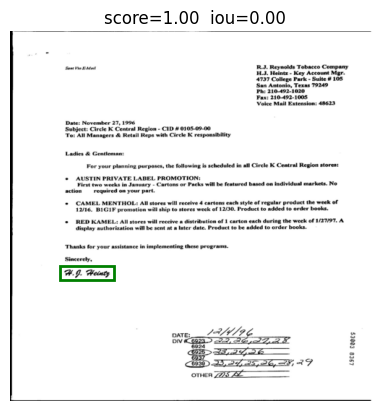

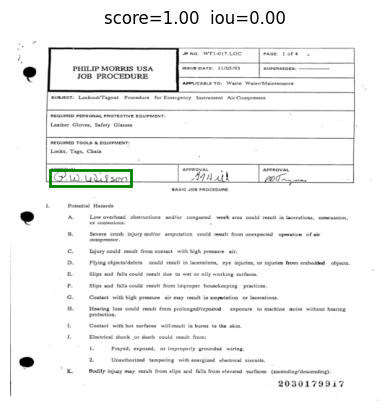

In [173]:
# Visualization: draw predicted box and GT on sample test images
import matplotlib.patches as patches
def visualize_predictions(model, dataloader, device, n=8):
    model.eval()
    imgs_shown = 0
    # plt.figure(figsize=(12, 6))
    with torch.no_grad():
        for batch in dataloader:
            imgs, targets = batch
            imgs_tensor = torch.stack(imgs).to(device)
            pred_boxes, pred_scores = model(imgs_tensor)
            pred_boxes = pred_boxes.cpu().numpy()
            pred_scores = torch.sigmoid(pred_scores).cpu().numpy()
            for img_t, pb, ps, tgt in zip(imgs, pred_boxes, pred_scores, targets):
                img = img_t.permute(1,2,0).cpu().numpy()  # HWC
                H, W = img.shape[:2]
                # convert normalized to pixel coords for prediction
                x, y, w, h = pb
                x1 = (x - w/2) * W
                y1 = (y - h/2) * H
                wpx = w * W
                hpx = h * H
                # Robustly extract GT box: support dict with 'boxes', tensor, or raw array/list
                if isinstance(tgt, dict) and 'boxes' in tgt:
                    gt_box = tgt['boxes'][0]
                else:
                    gt_box = tgt
                # ensure numpy array
                if isinstance(gt_box, torch.Tensor):
                    gt_box = gt_box.cpu().numpy()
                else:
                    gt_box = np.array(gt_box, dtype=float)
                # now unpack GT
                gx, gy, gw, gh = gt_box
                gx1 = (gx - gw/2) * W
                gy1 = (gy - gh/2) * H
                gwpx = gw * W
                ghpx = gh * H
                ax = plt.gca()
                ax.imshow(np.clip(img, 0, 1))
                # predicted box in red
                rectp = patches.Rectangle((x1, y1), wpx, hpx, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rectp)
                # gt box in green
                rectg = patches.Rectangle((gx1, gy1), gwpx, ghpx, linewidth=2, edgecolor='g', facecolor='none')
                ax.add_patch(rectg)
                ax.set_title(f'score={ps:.2f}  iou={iou_xywh(pb, gt_box):.2f}')
                ax.axis('off')
                imgs_shown += 1
                plt.show()
                if imgs_shown >= n:
                    return
    print('Done visualizing')

# Usage: after training and providing test_loader, run:
visualize_predictions(model, test_loader, device, n=2)

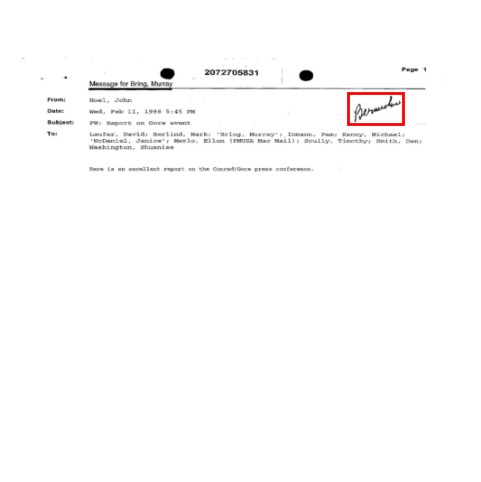

pred boxes sample: [9.4224658e-04 9.9988675e-01 1.9868153e-07 1.6048695e-13] pred score (sigmoid): 1.0


In [174]:
import matplotlib.patches as patches

for batch in train_loader:
    imgs, targets = batch  # collate_fn returns tuple(zip(*x))
    # imgs[0] is a tensor in [C,H,W] with values ~0..1
    img = imgs[0].permute(1,2,0).cpu().numpy()  # H,W,C, RGB in 0..1
    H, W = img.shape[:2]
    # boxes are stored as [x_center, y_center, w, h] (normalized)
    bbox = targets[0]['boxes'][0]
    # unpack correctly: x_center, y_center, width, height
    bbcx = float(bbox[0])
    bbcy = float(bbox[1])
    bbw = float(bbox[2])
    bbh = float(bbox[3])
    # convert normalized to pixels
    x1 = int((bbcx - bbw / 2.0) * W)
    y1 = int((bbcy - bbh / 2.0) * H)
    wpx = int(bbw * W)
    hpx = int(bbh * H)
    # draw using matplotlib patches (works with float RGB arrays)
    fig, ax = plt.subplots(1, figsize=(6,6))
    ax.imshow(np.clip(img, 0.0, 1.0))
    rect = patches.Rectangle((x1, y1), wpx, hpx, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.axis('off')
    plt.show()
    break

# quick sanity check: run model forward on one batch (if model defined)
if 'model' in globals():
    model.eval()
    with torch.no_grad():
        imgs_tensor = torch.stack(imgs).to(device)
        pb, ps = model(imgs_tensor)
        print("pred boxes sample:", pb[0].cpu().numpy(), "pred score (sigmoid):", float(torch.sigmoid(ps[0]).cpu()))